In [1]:
from pathlib import Path
from collections import Counter, OrderedDict
from itertools import permutations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tskit
import tszip
import sc2ts

In [2]:
def plot_mutational_spectra(
    ax,
    spectrum_alpha,
    spectrum_delta,
    spectrum_ba1,
    spectrum_ba2,
    spectrum_ba4,
    spectrum_ba5,
    title_text="",
    hide_xaxis=False,
    show_legend=True,
):
    mut_types = spectrum_alpha.keys()
    assert mut_types == spectrum_delta.keys()
    assert mut_types == spectrum_ba1.keys()
    assert mut_types == spectrum_ba2.keys()
    assert mut_types == spectrum_ba4.keys()
    assert mut_types == spectrum_ba5.keys()

    values_alpha = spectrum_alpha.values()
    values_delta = spectrum_delta.values()
    values_ba1 = spectrum_ba1.values()
    values_ba2 = spectrum_ba2.values()
    values_ba4 = spectrum_ba4.values()
    values_ba5 = spectrum_ba5.values()

    bar_width = 0.1
    x = np.arange(len(mut_types))

    ax.bar(x - 5/2 * bar_width, values_alpha, width=bar_width, label="Alpha-like")
    ax.bar(x - 3/2 * bar_width, values_delta, width=bar_width, label="Delta-like")
    ax.bar(x - 1/2 * bar_width, values_ba1, width=bar_width, label="Omicron BA.1-like")
    ax.bar(x + 1/2 * bar_width, values_ba2, width=bar_width, label="Omicron BA.2-like")
    ax.bar(x + 3/2 * bar_width, values_ba4, width=bar_width, label="Omicron BA.4-like")
    ax.bar(x + 5/2 * bar_width, values_ba5, width=bar_width, label="Omicron BA.5-like")

    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.set_title(title_text, loc="left")
    ax.set_ylabel("Proportion of mutations")
    ax.set_xlabel("Mutation type")
    ax.set_xticks(x, mut_types)

    if hide_xaxis:
        ax.get_xaxis().set_visible(False)

    if show_legend:
        ax.legend(frameon=False)

In [3]:
data_dir = Path("../data")

Examine the mutational spectra from the ARG

In [4]:
sc2ts_ts_file = data_dir / "sc2ts_viridian_v1.1.trees.tsz"
sc2ts_ts = tszip.decompress(sc2ts_ts_file)

In [5]:
sc2ts_df_node = sc2ts.node_data(sc2ts_ts)
sc2ts_df_node.head()

,pango,sample_id,scorpio,node_id,is_sample,is_recombinant,num_mutations,max_descendant_samples,date
0,B,Vestigial_ignore,.,0,False,False,0,0,2019-11-26
1,B,Wuhan/Hu-1/2019,.,1,False,False,0,2482157,2019-12-26
2,A,SRR11772659,.,2,True,False,1,255,2020-01-19
3,B,SRR11397727,.,3,True,False,0,1,2020-01-24
4,B,SRR11397730,.,4,True,False,0,1,2020-01-24


In [6]:
# Check the Scorpio labels in the dataset.
scorpio_counts = Counter(sc2ts_df_node.scorpio)
scorpio_counts

Counter({'Delta (B.1.617.2-like)': 580262,
         'Delta (AY.4-like)': 554344,
         'Omicron (BA.1-like)': 371961,
         'Omicron (BA.2-like)': 366063,
         'Alpha (B.1.1.7-like)': 317216,
         'Omicron (BA.5-like)': 194078,
         '.': 192205,
         'Delta (AY.4.2-like)': 92657,
         'Omicron (BA.4-like)': 27654,
         'Iota (B.1.526-like)': 11037,
         'Epsilon (B.1.429-like)': 8529,
         'Omicron (XBB.1.5-like)': 6032,
         'Gamma (P.1-like)': 5007,
         'Epsilon (B.1.427-like)': 4523,
         'Beta (B.1.351-like)': 3028,
         'Mu (B.1.621-like)': 1485,
         'Delta (B.1.617.2-like) +K417N': 1418,
         'Omicron (XE-like)': 1177,
         'B.1.1.318-like': 1116,
         'Omicron (XBB.1-like)': 1037,
         'Eta (B.1.525-like)': 896,
         'Omicron (XBB-like)': 785,
         'B.1.617.1-like': 495,
         'Omicron (Unassigned)': 375,
         'Zeta (P.2-like)': 355,
         'B.1.1.7-like+E484K': 319,
         'Lambda (C.

In [7]:
scorpio_groups = {
    "Alpha": [
        'Alpha (B.1.1.7-like)',
        'B.1.1.7-like+E484K',
    ],
    "Delta": [
        'Delta (B.1.617.2-like)',
        'Delta (B.1.617.2-like) +K417N',
        'Delta (AY.4-like)',
        'Delta (AY.4.2-like)',
    ],
    "Omicron BA.1": [
        'Omicron (BA.1-like)',
    ],
    "Omicron BA.2": [
        'Omicron (BA.2-like)',
    ],
    "Omicron BA.4": [
        'Omicron (BA.4-like)',
    ],
    "Omicron BA.5": [
        'Omicron (BA.5-like)',
    ]
}

In [8]:
total_count = sum(scorpio_counts.values())  # Excluding unassigned
voc_count = 0
for group in scorpio_groups:
    for label in scorpio_groups[group]:
        voc_count += scorpio_counts[label]
print(f"Total: {total_count}")
print(f"VoC: {voc_count} ({round(voc_count / total_count, 2) * 100}%)")

Total: 2744713
VoC: 2505972 (91.0%)


In [9]:
sc2ts_df_mut = sc2ts.mutation_data(sc2ts_ts)\
    .merge(sc2ts_df_node, left_on='node', right_on='node_id', how='left')
sc2ts_df_mut.head(5)

,mutation_id,site_id,position,parent,node,inherited_state,derived_state,date_x,num_descendants,num_inheritors,pango,sample_id,scorpio,node_id,is_sample,is_recombinant,num_mutations,max_descendant_samples,date_y
0,0,24,25,-1,644280,T,A,2021-09-22,1,1,AY.4,ERR7245262,Delta (AY.4-like),644280,True,False,4,1,2021-10-16
1,1,37,38,-1,12915,A,G,2020-04-21,1,1,B.1.225,ERR4969024,.,12915,True,False,1,1,2020-05-10
2,2,42,43,-1,344292,T,A,2021-07-17,3,3,AY.3,SRR15391186,Delta (B.1.617.2-like),344292,True,False,1,3,2021-07-20
3,3,42,43,-1,427855,T,C,2021-07-26,2,2,AY.25.1,SRR15864152,Delta (B.1.617.2-like),427855,True,False,1,2,2021-08-18
4,4,42,43,-1,670767,T,C,2021-08-21,2,2,AY.5,ERR7240981,Delta (B.1.617.2-like),670767,True,False,5,2,2021-10-24


In [10]:
def get_mutational_spectrum_ts(df_mut, scorpio_labels):
    df_mut = df_mut[df_mut.scorpio.isin(scorpio_labels)]
    spectrum = OrderedDict()
    for p in permutations(tskit.ALLELES_ACGT, 2):
        spectrum[p[0] + ">" + p[1]] = 0
    for a, b in zip(df_mut.inherited_state, df_mut.derived_state):
        # Ignore indels
        if a == "-" or b == "-":
            continue
        # There was at least one mutation like this in the UShER tree.
        if a == b:
            continue
        spectrum[a + ">" + b] += 1
    tot_muts = sum(spectrum.values())
    for x in spectrum:
        spectrum[x] /= tot_muts
    print(f"Sum: {sum(spectrum.values())}")
    return spectrum

In [11]:
spectrum_alpha_arg = get_mutational_spectrum_ts(sc2ts_df_mut, scorpio_groups["Alpha"])
spectrum_delta_arg = get_mutational_spectrum_ts(sc2ts_df_mut, scorpio_groups["Delta"])
spectrum_ba1_arg = get_mutational_spectrum_ts(sc2ts_df_mut, scorpio_groups["Omicron BA.1"])
spectrum_ba2_arg = get_mutational_spectrum_ts(sc2ts_df_mut, scorpio_groups["Omicron BA.2"])
spectrum_ba4_arg = get_mutational_spectrum_ts(sc2ts_df_mut, scorpio_groups["Omicron BA.4"])
spectrum_ba5_arg = get_mutational_spectrum_ts(sc2ts_df_mut, scorpio_groups["Omicron BA.5"])

Sum: 1.0
Sum: 1.0
Sum: 1.0
Sum: 1.0
Sum: 1.0
Sum: 1.0


Examine the mutational spectra from Bloom et al. (2023)
https://pmc.ncbi.nlm.nih.gov/articles/PMC10124870/

In [12]:
bloom_url = "https://media.githubusercontent.com/media/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/mutation_counts/aggregated.csv"
bloom_df = pd.read_csv(bloom_url)
bloom_df = bloom_df[~bloom_df.exclude].reset_index(drop=True)
bloom_df.head(5)

,protein,aa_mutation,nt_mutation,codon_change,synonymous,count,nt_site,reference_nt,clade_founder_nt,exclude,exclude_reason,clade,subset,codon_position,four_fold_degenerate
0,ORF1ab,P5401L,C16466T,CCA>CTA,False,62,16466,C,C,False,NaN,19A,all,2,False
1,M,I82T,T26767C,ATC>ACC,False,54,26767,T,T,False,NaN,19A,all,2,False
2,ORF1a;ORF1ab,F924F;F924F,C3037T,TTC>TTT;TTC>TTT,True,49,3037,C,C,False,NaN,19A,all,3,False
3,ORF1ab,A6319V,C19220T,GCT>GTT,False,46,19220,C,C,False,NaN,19A,all,2,False
4,ORF1ab,I5658V,A17236G,ATA>GTA,False,45,17236,A,A,False,NaN,19A,all,1,False


In [13]:
def get_mutational_spectrum_bloom(df, nextclade_labels, only_degenerate=False):
    df_tmp = df[df.clade.isin(nextclade_labels)].reset_index(drop=True)
    if only_degenerate:
        df_tmp = df_tmp[df_tmp.four_fold_degenerate].reset_index(drop=True)
    spectrum = OrderedDict()
    for p in permutations(tskit.ALLELES_ACGT, 2):
        spectrum[p[0] + ">" + p[1]] = 0
    for row in df_tmp.itertuples():
        a = row.nt_mutation[0]
        b = row.nt_mutation[-1]
        spectrum[a + ">" + b] += row.count  # NOTE: Important
    tot_muts = sum(spectrum.values())
    for x in spectrum:
        spectrum[x] /= tot_muts
    print(f"Sum: {sum(spectrum.values())}")
    return spectrum

In [14]:
# Including non-degenerate sites
spectrum_alpha_bloom = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["20I"])
spectrum_delta_bloom = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["21I", "21J"])
spectrum_ba1_bloom = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["21K"])
spectrum_ba2_bloom = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["21L"])
spectrum_ba4_bloom = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["22A"])
spectrum_ba5_bloom = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["22B"])

Sum: 0.9999999999999999
Sum: 1.0
Sum: 1.0
Sum: 1.0
Sum: 1.0
Sum: 1.0


In [15]:
# Excluding non-degenerate sites
spectrum_alpha_bloom_deg = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["20I"], only_degenerate=True)
spectrum_delta_bloom_deg = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["21I", "21J"], only_degenerate=True)
spectrum_ba1_bloom_deg = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["21K"], only_degenerate=True)
spectrum_ba2_bloom_deg = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["21L"], only_degenerate=True)
spectrum_ba4_bloom_deg = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["22A"], only_degenerate=True)
spectrum_ba5_bloom_deg = get_mutational_spectrum_bloom(bloom_df, nextclade_labels=["22B"],only_degenerate=True)

Sum: 1.0
Sum: 1.0
Sum: 1.0
Sum: 1.0
Sum: 1.0
Sum: 1.0


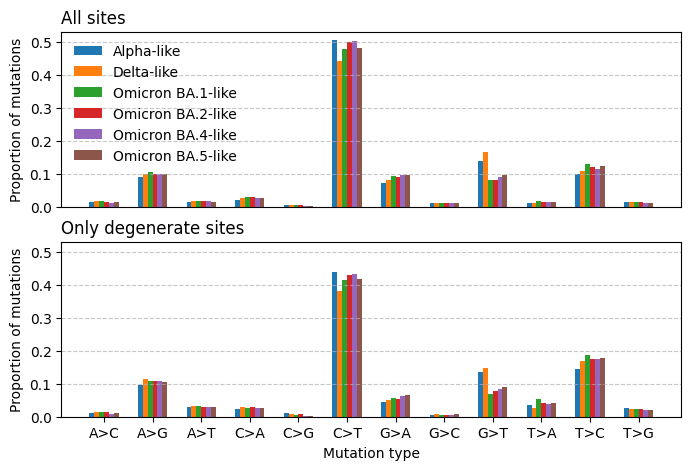

In [16]:
# The mutational spectra including and excluding non-degenerate sites are different.
_, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(8, 5))

plot_mutational_spectra(
    ax=ax[0],
    spectrum_alpha=spectrum_alpha_bloom,
    spectrum_delta=spectrum_delta_bloom,
    spectrum_ba1=spectrum_ba1_bloom,
    spectrum_ba2=spectrum_ba2_bloom,
    spectrum_ba4=spectrum_ba4_bloom,
    spectrum_ba5=spectrum_ba5_bloom,
    title_text="All sites",
    hide_xaxis=True,
)

# This is shown in Figure 1 of Bloom et al.
plot_mutational_spectra(
    ax=ax[1],
    spectrum_alpha=spectrum_alpha_bloom_deg,
    spectrum_delta=spectrum_delta_bloom_deg,
    spectrum_ba1=spectrum_ba1_bloom_deg,
    spectrum_ba2=spectrum_ba2_bloom_deg,
    spectrum_ba4=spectrum_ba4_bloom_deg,
    spectrum_ba5=spectrum_ba5_bloom_deg,
    title_text="Only degenerate sites",
    show_legend=False,
)

Compare the all-site mutational spectra from the ARG and Bloom et al.

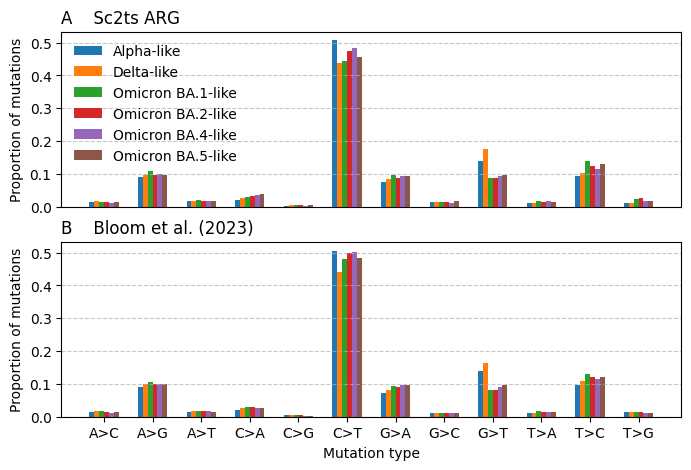

In [17]:
_, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(8, 5))

plot_mutational_spectra(
    ax=ax[0],
    spectrum_alpha=spectrum_alpha_arg,
    spectrum_delta=spectrum_delta_arg,
    spectrum_ba1=spectrum_ba1_arg,
    spectrum_ba2=spectrum_ba2_arg,
    spectrum_ba4=spectrum_ba4_arg,
    spectrum_ba5=spectrum_ba5_arg,
    title_text="A    Sc2ts ARG",
    hide_xaxis=True,
)

# This is shown in Figure 1 of Bloom et al.
plot_mutational_spectra(
    ax=ax[1],
    spectrum_alpha=spectrum_alpha_bloom,
    spectrum_delta=spectrum_delta_bloom,
    spectrum_ba1=spectrum_ba1_bloom,
    spectrum_ba2=spectrum_ba2_bloom,
    spectrum_ba4=spectrum_ba4_bloom,
    spectrum_ba5=spectrum_ba5_bloom,
    title_text="B    Bloom et al. (2023)",
    show_legend=False,
)

Compare the all-site mutational spectra from the ARG, Bloom et al., and Viridian UShER phylogeny.

In [18]:
usher_ts_file = data_dir / "usher_viridian_inter_v1.1.trees.tsz"
usher_ts = tszip.decompress(usher_ts_file)
usher_ts

In [19]:
# No Scorpio labels, so get from the sc2ts dataset.
# NOTE: This means we only analyse the samples.
usher_df_node = sc2ts.node_data(usher_ts)\
    .merge(sc2ts_df_node, left_on='sample_id', right_on='sample_id', how='left')
usher_df_node.head()

,Date_tree,sample_id,node_id_x,is_sample_x,is_recombinant_x,num_mutations_x,max_descendant_samples_x,pango,scorpio,node_id_y,is_sample_y,is_recombinant_y,num_mutations_y,max_descendant_samples_y,date
0,2020-01-19,SRR11772659,0,True,False,0,1,A,.,2.0,True,False,1.0,255.0,2020-01-19
1,2020-01-24,SRR11397727,1,True,False,0,1,B,.,3.0,True,False,0.0,1.0,2020-01-24
2,2020-01-25,SRR11597198,2,True,False,0,1,A,.,6.0,True,False,0.0,1.0,2020-01-25
3,2020-01-25,SRR11597221,3,True,False,0,1,A,.,7.0,True,False,0.0,1.0,2020-01-25
4,2020-01-28,SRR11597143,4,True,False,2,1,B,.,10.0,True,False,3.0,1.0,2020-01-28


In [20]:
usher_df_mut = sc2ts.mutation_data(usher_ts)\
    .merge(usher_df_node, left_on='node', right_on='node_id_x', how='left')
usher_df_mut.head()

,mutation_id,site_id,position,parent,node,inherited_state,derived_state,num_descendants,num_inheritors,Date_tree,...,num_mutations_x,max_descendant_samples_x,pango,scorpio,node_id_y,is_sample_y,is_recombinant_y,num_mutations_y,max_descendant_samples_y,date
0,0,1,269,-1,2950593,G,A,39,39,,...,1,39,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaT
1,1,1,269,-1,74546,G,A,1,1,2021-01-04,...,1,1,B.1.177,.,90316.0,True,False,1.0,1.0,2021-01-04
2,2,1,269,-1,2941538,G,A,9,9,,...,1,9,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaT
3,3,1,269,-1,2930168,G,A,23,23,,...,2,23,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaT
4,4,1,269,-1,2810634,G,A,10,10,,...,2,10,<NA>,<NA>,NaN,NaN,NaN,NaN,NaN,NaT


In [21]:
# Subset down to the samples for which we have Scorpio labels.
usher_df_mut = usher_df_mut[~usher_df_mut.scorpio.isna()]
len(usher_df_mut)

1219620

In [22]:
spectrum_alpha_usher = get_mutational_spectrum_ts(usher_df_mut, scorpio_groups["Alpha"])
spectrum_delta_usher = get_mutational_spectrum_ts(usher_df_mut, scorpio_groups["Delta"])
spectrum_ba1_usher = get_mutational_spectrum_ts(usher_df_mut, scorpio_groups["Omicron BA.1"])
spectrum_ba2_usher = get_mutational_spectrum_ts(usher_df_mut, scorpio_groups["Omicron BA.2"])
spectrum_ba4_usher = get_mutational_spectrum_ts(usher_df_mut, scorpio_groups["Omicron BA.4"])
spectrum_ba5_usher = get_mutational_spectrum_ts(usher_df_mut, scorpio_groups["Omicron BA.5"])

Sum: 1.0
Sum: 1.0
Sum: 1.0
Sum: 1.0
Sum: 1.0
Sum: 1.0


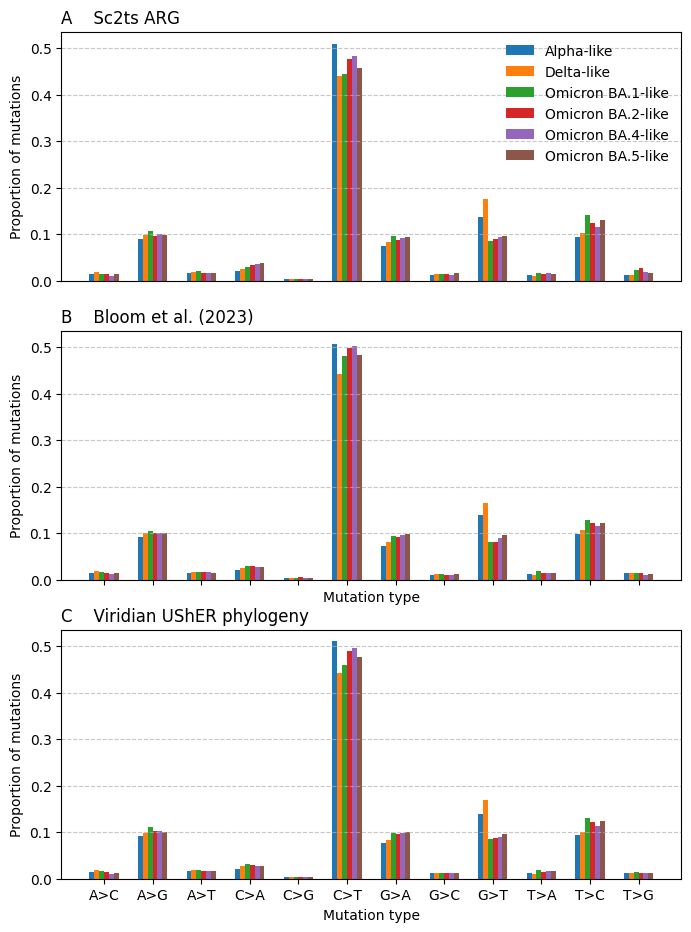

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(8, 11))

plot_mutational_spectra(
    ax=ax[0],
    spectrum_alpha=spectrum_alpha_arg,
    spectrum_delta=spectrum_delta_arg,
    spectrum_ba1=spectrum_ba1_arg,
    spectrum_ba2=spectrum_ba2_arg,
    spectrum_ba4=spectrum_ba4_arg,
    spectrum_ba5=spectrum_ba5_arg,
    title_text="A    Sc2ts ARG",
    hide_xaxis=True,
)

# This is shown in Figure 1 of Bloom et al.
plot_mutational_spectra(
    ax=ax[1],
    spectrum_alpha=spectrum_alpha_bloom,
    spectrum_delta=spectrum_delta_bloom,
    spectrum_ba1=spectrum_ba1_bloom,
    spectrum_ba2=spectrum_ba2_bloom,
    spectrum_ba4=spectrum_ba4_bloom,
    spectrum_ba5=spectrum_ba5_bloom,
    title_text="B    Bloom et al. (2023)",
    show_legend=False,
)

plot_mutational_spectra(
    ax=ax[2],
    spectrum_alpha=spectrum_alpha_usher,
    spectrum_delta=spectrum_delta_usher,
    spectrum_ba1=spectrum_ba1_usher,
    spectrum_ba2=spectrum_ba2_usher,
    spectrum_ba4=spectrum_ba4_usher,
    spectrum_ba5=spectrum_ba5_usher,
    title_text="C    Viridian UShER phylogeny",
    show_legend=False,
)

In [ ]:
fig.savefig("../figures/mutational_spectra.pdf")